### Задачи к Лекции 3

__Исходные данные__ 

Дан файл **"mlbootcamp5_train.csv"**. В нем содержатся данные об опросе 70000 пациентов с целью определения наличия заболеваний сердечно-сосудистой системы (ССЗ). Данные в файле промаркированы и если у человека имееются ССЗ, то значение **cardio** будет равно 1, в противном случае - 0. Описание и значения полей представлены во второй лекции.

__Загрузка файла__

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("mlbootcamp5_train.csv", 
                 sep=";", 
                 index_col="id")
# Делаем one-hot кодирование
chol = pd.get_dummies(df["cholesterol"], prefix="chol")
gluc = pd.get_dummies(df["gluc"], prefix="gluc")
df = pd.concat([df, chol, gluc], axis=1)

# Делаем пол бинарным признаком
df["gender_bin"] = df["gender"].map({1: 0, 2: 1})
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,chol_1,chol_2,chol_3,gluc_1,gluc_2,gluc_3,gender_bin
id,,,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,True,False,False,True,False,False,1
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,False,False,True,True,False,False,0
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,False,False,True,True,False,False,0
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,True,False,False,True,False,False,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,True,False,False,True,False,False,0


## Классы в Python

Нередко, возникает необходимость создания объектов с каким-нибудь внутренним поведением и состоянием. Примерами таких объектов являются классификаторы sklearn, массивы numpy и много другое. Такой объект можно объявить с помощью ключевого слова **class**

```python
class SomeObject:
    def __init__(self, depth):
        self.a = depth
        self.target = None
        
    def fit(self, data, target):
        self.target = data
        # magic
        return 
    
    def predict(self, data):
        return self.target    
```

После этого в коде можно будет создать экземпляр данного класса
```python
a = SomeObject(depth=5)
a.fit(data, target)
a.predict(data)
```

## Задачи

**1. В sklearn на данный момент отсутствует функционал для построения деревьев решений из категориальных данных, поэтому его нужно сделать самостоятельно и проверить его работу. Что нужно сделать:**

* __создать классификатор используя только pandas, numpy и scipy. Необходимо его сделать самому, используя исключительно только numpy, pandas и scipy (запрещено использовать sklearn и прочие библиотеки). Напоминаю, что для категориальных данных операция < или > не имеют смысла (использовать только != и ==). Гиперпараметром данного классификатора должна быть максимальная глубина дерева.__
* __Проверить работу данного классификатора на наборе ("gender", "cholesterol", "gluc").__
* __С помощью кросс-валидации найти оптимальную глубину этого дерева. Для вашего классификатора GridSearchCV не подойдет, придется это сделать также самостоятельно.__
* __Нарисовать полученное дерево (я должен понять, как и откуда вы его нарисовали).__

Алгоритм работы классификатора:
 1. Перебираем все возможные признаки и смотрим либо неопределенность Джини, либо прирост информации. Это даст критерий разбиения в виде "признак == значение"
 2. Если выборка полученная при разбиении состоит из объектов одного класса (соответсвует нулевой энтропии), то данный лист просто возвращает значение этого класса.
 3. В противном случае, образуется новый узел и для него начинаем с пункта 1.
 4. Если достигли максимальной глубины, то вместа узла создаем лист, который возвращает самое вероятное значение.
 
__Замечание:__ в этой задаче не нужно использовать onehot-кодирование.

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

X = df[["gender", "cholesterol", "gluc"]]
y = df["cardio"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 

#обучение дерева с ограничением глубины
from sklearn.tree import DecisionTreeClassifier #реализует алгоритм решений для задач классификации
tree = DecisionTreeClassifier(criterion="entropy", max_depth=3)
tree.fit(X_train, y_train) #fit обучает модель на данных, которые ему предоставят

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [7]:
from sklearn.model_selection import GridSearchCV #инструмент для полного перебора по заданным параметрам с кросс-валидацией

params = {"max_depth": [1, 2, 3]} #глубина 3 для перебора

# Создание и выполнение GridSearch
grid = GridSearchCV(
    DecisionTreeClassifier(criterion="entropy"), #DecisionTreeClassifier() - Базовый классификатор, для которого подбираются параметры
    param_grid=params,
    cv=5,  # 5-fold кросс-валидация - стандартное значение, можно 10 для более точного усреднения
    scoring="accuracy" #Метрика для оценки качества (доля правильных ответов)
)
grid.fit(X_train, y_train)

# Лучшая глубина
best_depth = grid.best_params_["max_depth"]
print(f"Оптимальная глубина: {best_depth}")

Оптимальная глубина: 3


In [8]:
# Модель с оптимальной глубиной
final_tree = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=best_depth
)
final_tree.fit(X_train, y_train)

# Оценка качества
accuracy = final_tree.score(X_test, y_test)
print(f"Точность на тесте: {accuracy:3f}")

Точность на тесте: 0.586048


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

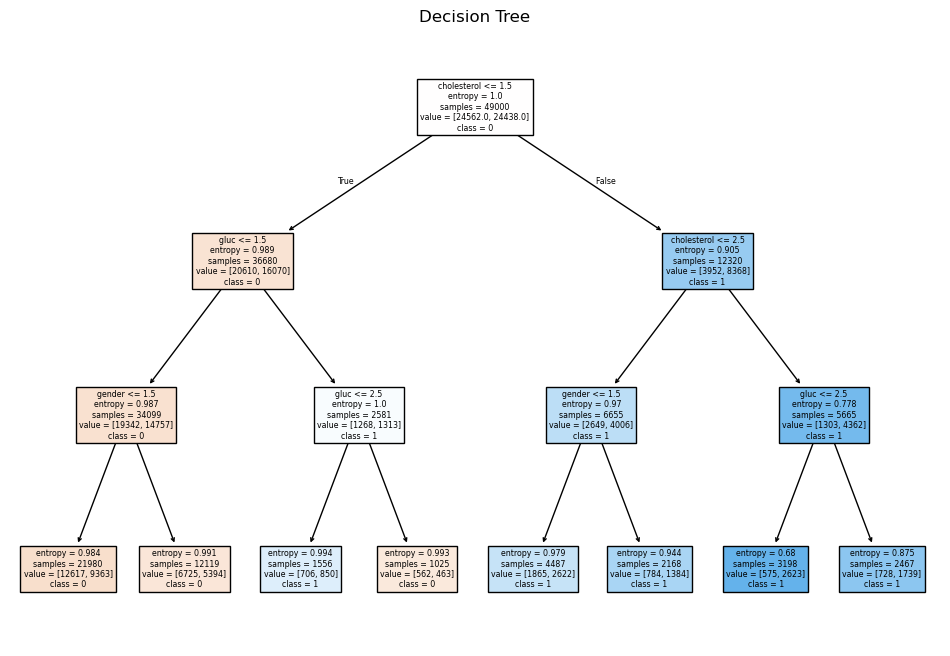

In [11]:
# Визуализация дерева решений
from sklearn.tree import DecisionTreeClassifier, plot_tree
plt.figure(figsize=(12,8))
plot_tree(final_tree, feature_names=X.columns, class_names=np.unique(y).astype(str), filled=True)
plt.title("Decision Tree")
plt.show()